In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import analysis as e2
from fxns import running_mean
from importlib import reload

In [3]:
colors = plt.cm.Set1.colors

def plot_reward(data_collection, labels, expt = 0, smoothing = 100, **kwargs):
    '''
    data_collection: datafilter class 
    TODO: need to specify which data --currently only training data
    '''
    title = kwargs.get('title', ' ')
    plt.figure()
    for i, sep in enumerate(data_collection):
        dat = sep.get_expt_data(expt_type=expt)
        for ii, d in enumerate(dat):
            if ii == 0:
                plt.plot(running_mean(d['total_reward'], smoothing), c=colors[i], label=labels[i])
            else:
                plt.plot(running_mean(d['total_reward'], smoothing), c=colors[i])
    plt.legend(bbox_to_anchor=(1.05,0.95))
    plt.title(title)
    plt.show()
    plt.close()

class single_record(object):
    def __init__(self, save_id):
        parent_dir = './data/'
        self.data = pickle.load(open(parent_dir + f'results/{save_id}_data.p', 'rb'))

def scale_reward(df_obj):
    scaled_r = []
    for i in range(len(df_obj.info)):
        scaled_r.append([])
        target = eval(df_obj.info.iloc[i]['rewards'].strip('{}').split(':')[0])
        starts = df_obj.data[i]['starts']
        nevents = int(df_obj.info.iloc[i]['num_events'])

        for ind, start in enumerate(starts):
            steps_from_target = abs(target[0]-start[0]) + abs(target[1]-start[1])
            theoretical_max = (nevents-steps_from_target)/2
            scaled_r[i].append(df_obj.data[i]['total_reward'][ind]/theoretical_max)
    
    return scaled_r

def scale_reward_single(data_obj, target):
    scaled_r = []
    starts = data_obj['starts'][0:-2]
    for ind, start in enumerate(starts):
        nevents = data_obj['trial_length'][ind]
        steps_from_target = abs(target[0]-start[0]) + abs(target[1]-start[1])
        theoretical_max = (nevents-steps_from_target)/2
        scaled_r.append(data_obj['total_reward'][ind]/theoretical_max)

    return scaled_r

def plot_train_test(training_data, testing_data_set):
    ## this is a data filter
    plt.figure()
    plt.plot(training_data)

    offset = len(training_data)
    for testing_data in testing_data_set:
        testing_reshape = np.zeros(offset + len(testing_data))
        testing_reshape[0:offset] = np.nan
        testing_reshape[offset-1:-1] = testing_data
        plt.plot(testing_reshape)
    

In [4]:
parent_dir = './data/'
df = pd.read_csv(parent_dir + 'sep2020.csv')
experiment_types = ['Training',
                    'MF Only',
                    'EC ($\psi$)',
                    'EC ($\phi$)',
                    'MF Only (free)',
                    'EC ($\psi$)(free)',
                    'EC ($\phi$)(free)' ]

In [4]:
training = e2.DataFilter(df, expt_type=[0])
MF = e2.DataFilter(df, expt_type=[4])
EC = e2.DataFilter(df, expt_type=[5])

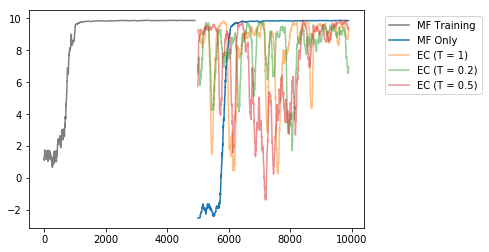

In [37]:
smoothing = 100
plt.figure()
plt.plot(running_mean(training.data[0]['total_reward'],smoothing), 'gray', label='MF Training')
offset = len(training.data[0]['total_reward'])

smoothed_MF = running_mean(MF.data[0]['total_reward'][0:5000],smoothing)
plt.plot(np.arange(len(smoothed_MF))+offset, smoothed_MF ,label='MF Only')
for j in range(2,9,3):
    i = j
    smoothed_EC = running_mean(EC.data[i]['total_reward'], smoothing)
    plt.plot(np.arange(len(smoothed_EC))+offset, smoothed_EC, label=f"EC (T = {EC.info.iloc[i]['mem_temp']})", alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,0.995))

plt.show()
plt.close()

In [34]:
EC_test = single_record('f8e89cf3-a8a8-4b5c-9708-46719d0bb806')

'016375f6-eb4f-46b5-8ce1-80a6ad0ad603'

In [5]:
save_id = '7e0a8d56-01b7-4168-9d6c-eae17873cc0e'
anim = single_record(save_id)
load_env_id = (df.loc[df['save_id']== save_id]['load_from']).item()
reward_info = (df.loc[df['save_id']== save_id]['rewards']).item().strip('{}')
reward_loc = eval(reward_info.split(':')[0])
reward_mag = float(reward_info.split(':')[1])


env = pickle.load(open(parent_dir + f'environments/{load_env_id}_env.p', 'rb'))
env.rewards = {reward_loc:reward_mag}

<IPython.core.display.Javascript object>


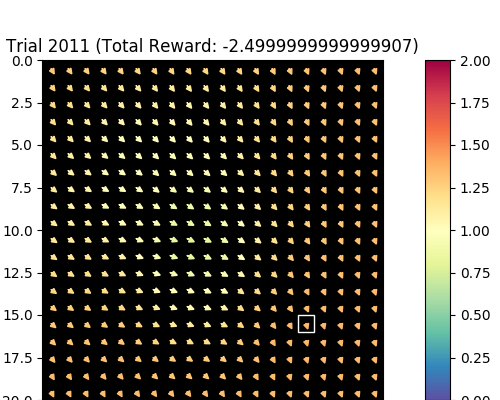

In [7]:
%matplotlib notebook
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import matplotlib.cm as cmx
import matplotlib.patches as mpatches
import matplotlib.animation as animation
from scipy.stats import entropy


def make_arrows(action, probability):
    if probability == 0:
        dx, dy = 0, 0
        head_w, head_l = 0, 0
    else:
        dxdy = [(0.0, 0.25),  # D
                (0.0, -0.25),  # U
                (0.25, 0.0),  # R
                (-0.25, 0.0),  # L
                (0.1, -0.1),  # points right and up #J
                (-0.1, 0.1),  # points left and down # P
                ]
        dx, dy = dxdy[action]

        head_w, head_l = 0.1, 0.1

    return dx, dy, head_w, head_l


rewards = env.rewards
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_axes([0, 0, 0.85, 0.85])
axc = fig.add_axes([0.85, 0, 0.05, 0.85])

ax1.set_aspect('equal')

ax1.invert_yaxis()

cmap = plt.cm.Spectral_r
vmax= 2

cNorm = colors.Normalize(vmin=0, vmax=vmax)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
cb1 = colorbar.ColorbarBase(axc, cmap=cmap, norm=cNorm)



def animate_policy(r):
    k = r+2000
    ax1.set_title(f"Trial {k} (Total Reward: {anim.data['total_reward'][k]})")
    # make base grid
    ax1.patches = []
    ax1.pcolor(env.grid, vmin=0, vmax=vmax, cmap='bone')

    # add patch for reward location/s (red)
    for rwd_loc in rewards:
        rwd_r, rwd_c = rwd_loc
        ax1.add_patch(plt.Rectangle((rwd_c, rwd_r), width=0.99, height=1, linewidth=1, ec='white', fill=False))

    chance_threshold =0.18
    
    
    policy_array = anim.data['pol_tracking'][k]
    for i in range(env.r):
        for j in range(env.c):
            policy = tuple(policy_array[i, j])

            dx, dy = 0.0, 0.0
            for ind, k in enumerate(policy):
                action = ind
                prob = k
                if prob < 0.01:
                    pass
                else:
                    dx1, dy1, head_w, head_l = make_arrows(action, prob)
                    dx += dx1*prob
                    dy += dy1*prob
            if dx ==0.0 and dy == 0.0:
                pass
            else:
                colorVal1 = scalarMap.to_rgba(entropy(policy))
                x,y = j+0.5, i+0.5
                arrow = mpatches.FancyArrow(x,y,dx,dy, color=colorVal1, head_width=0.3, head_length=0.3)
                ax1.add_patch(arrow)


Writer = animation.writers['pillow']
writer = Writer(fps=200, metadata=dict(artist='Me'), bitrate=100)
ani = animation.FuncAnimation(fig, animate_policy, frames=100, repeat=True)



<IPython.core.display.Javascript object>


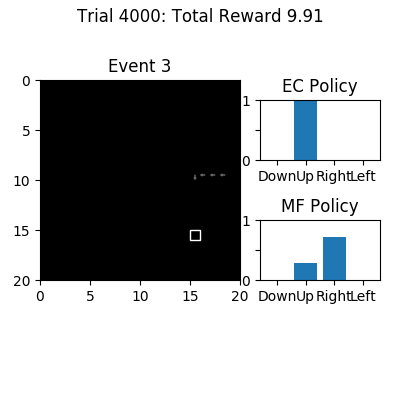

In [90]:
trial= 4000

fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0.1,.3, 0.5, 0.5]) #[left,bottom,width,height] 
ax2 = fig.add_axes([.65,0.6,0.3, 0.15])
ax3 = fig.add_axes([0.65,0.3,0.3, 0.15])
ax2.set_title('')
ax2.set_ylim([0,1])

plt.suptitle(f"Trial {trial}: Total Reward {anim.data['total_reward'][trial]}")

ax.patches = []
ax.pcolor(env.grid, vmin=0, vmax=vmax, cmap='bone')
ax.add_patch(plt.Rectangle((15,15), width=0.99, height=1, linewidth=1, ec='white', fill=False))
ax.set_aspect('equal')
ax.invert_yaxis()


trajectory = np.vstack(np.vstack(anim.data['sar'][trial])[:,0])
rows = trajectory[:,0]
cols = trajectory[:,1]
dx, dy = [],[]
for ind in range(len(rows)-1):
    dx.append(rows[ind+1]-rows[ind])
    dy.append(cols[ind+1]-cols[ind])

dx=np.asarray(dx)*0.25
dy=np.asarray(dy)*0.25

def animate_trajectory(i):
    if i == 0:
        ax.patches = []
        ax.add_patch(plt.Rectangle((15,15), width=0.99, height=1, linewidth=1, ec='white', fill=False))

    ax.set_title(f"Event {i}")
    
    #ax.pcolor(env.grid, vmin=0, vmax=vmax, cmap='bone')
    # make base grid
    arrow = mpatches.FancyArrow(rows[i]+0.5,cols[i]+0.5,dx[i],dy[i], head_width=0.2, head_length=0.2, color='white',alpha=0.3)
    ax.add_patch(arrow) 
    ax2.cla()
    ax2.set_xticks([0,1,2,3])
    ax2.set_xticklabels(['Down','Up','Right','Left'])
    ax2.set_yticklabels([0,'',1])
    ax2.set_ylim([0,1])
    ax2.set_title('EC Policy')
    ax2.bar(np.arange(4),np.vstack(np.vstack(anim.data['sar'][trial])[:,1])[i])
    
    
    
    ax3.cla()
    ax3.set_xticks([0,1,2,3])
    ax3.set_yticklabels([0,'',1])
    ax3.set_ylim([0,1])
    ax3.set_title('MF Policy')
    ax3.bar(np.arange(4),list(anim.data['pol_tracking'][trial][rows[i],cols[i]]))
    ax3.set_xticklabels(['Down','Up','Right','Left'])

    
Writer = animation.writers['pillow']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=100)
ani = animation.FuncAnimation(fig, animate_trajectory, frames=len(trajectory), repeat=True, blit=True)

plt.show()

In [89]:
print(len(anim.data['total_reward']))


5000


In [ ]:
training_dat = single_record('59bdc055-56f7-4095-afe6-bc0286f99dff')
testing_ec = single_record('0a8db602-9945-4832-b4db-de485a2f82c0')
testing_mf = single_record('9e26aadf-780e-49c9-a1dc-d0be3f2f1757')

In [ ]:
frozen_w = e2.DataFilter(df,expt_type=[2], load_from=['59bdc055-56f7-4095-afe6-bc0286f99dff'])

unfrozen_w = e2.DataFilter(df,expt_type=[5], load_from=['59bdc055-56f7-4095-afe6-bc0286f99dff'])

In [ ]:
train = training_dat.data['total_reward']
smoothing =1
ec =scale_reward_single(testing_ec.data, target=(15,15))
mf =scale_reward_single(testing_mf.data, target=(15,15))
plot_train_test(running_mean(train,smoothing), 
                [running_mean(ec, smoothing),
                 running_mean(mf, smoothing)])

In [ ]:
for i in scaled_r:
    plt.plot(running_mean(i,100), alpha=0.3)

### Training

In [ ]:
reload(e2)
# separate tasks:
openfield = e2.DataFilter(df, env_type=['None'], rho=[0.0])
obstacles = e2.DataFilter(df, env_type=['None'], rho=[0.1])
fourrooms = e2.DataFilter(df, env_type=['room'])
envs = [openfield, obstacles,fourrooms]
env_names = ['openfield', 'obstacles', '4rooms']
# plot 
plot_reward(envs, env_names, expt = 0 )

In [ ]:
# show training by env type
fig, ax = plt.subplots(1,3, sharey=True)
smoothing = 100 
for j, task in enumerate(envs):
    title = env_names[j]
    A_ = e2.DataFilter(task.info, arch = ['A'])
    B_ = e2.DataFilter(task.info, arch = ['B'])

    data_collection = [A_, B_]
    labels = ['No SR', 'With SR']
    
    for i, sep in enumerate(data_collection):
        dat = sep.get_expt_data(expt_type=0)
        for ii, d in enumerate(dat):
            if ii == 0:
                ax[j].plot(running_mean(d['total_reward'], smoothing), c=colors[i], label=labels[i])
            else:
                ax[j].plot(running_mean(d['total_reward'], smoothing), c=colors[i])
    
    ax[2].legend(bbox_to_anchor=(1.05,0.95))
    ax[j].set_title(title)    
    
    
    #plot_reward(arch, ['A', 'B'], title=env_names[j], expt=0)
    #plot_reward(arch, ['A', 'B'], title=env_names[i], expt=4)

### Testing

In [ ]:
for test_expt in [1,2,4,5]:
    print(experiment_types[test_expt])
    fig, ax = plt.subplots(1,3, sharey=True)
    smoothing = 100 
    for j, task in enumerate(envs):
        title = env_names[j]
        A_ = e2.DataFilter(task.info, arch = ['A'])
        B_ = e2.DataFilter(task.info, arch = ['B'])

        data_collection = [A_, B_]
        labels = ['No SR', 'With SR']

        for i, sep in enumerate(data_collection):
            dat = sep.get_expt_data(expt_type=test_expt)
            for ii, d in enumerate(dat):
                if ii == 0 and j ==0:
                    ax[j].plot(running_mean(d['total_reward'], smoothing), c=colors[i], label=labels[i])
                else:
                    ax[j].plot(running_mean(d['total_reward'], smoothing), c=colors[i])

        fig.legend(loc='lower center', bbox_to_anchor=(0.5,0), ncol=2)
        ax[j].set_title(title)  
    plt.show()
    plt.close()

In [ ]:
task = openfield

mf_only = e2.DataFilter(task.info,arch=['B'],expt_type=[1,4])
with_ec = e2.DataFilter(task.info,arch=['B'], expt_type=[2,5])
subtask = with_ec


lb = -2.5
ub = 125
smoothing = 100
for i in range(len(subtask.data)):
    #print(subtask.info.iloc[i])
    tag = f"Forget:{subtask.info.iloc[i]['use_pvals']} | alpha:{subtask.info.iloc[i]['alpha']} | beta:{subtask.info.iloc[i]['beta']}"
    x = running_mean((1/(ub-lb))*(np.asarray(subtask.data[i]['total_reward']) -lb), smoothing)
    plt.plot(x, label=tag)
#plt.ylim((0,1))
plt.legend(bbox_to_anchor=(1.05,0.95))
plt.show()

In [ ]:
task = openfield

mf_only = e2.DataFilter(task.info, expt_type=[1,4])
with_ec = e2.DataFilter(task.info, expt_type=[2,5], beta=['10000'])

stuff = [mf_only, with_ec]
print(len(mf_only.data))
for i in mf_only.data:
    
    plt.plot(running_mean(i['total_reward'],100))
plt.show()
plt.close()

plt.figure()
for ii, i in enumerate(with_ec.data):
    
    plt.plot(running_mean(i['total_reward'], 100))
plt.show()
plt.close()

In [ ]:
for j in with_ec.info.columns:
    print(j)
    for ii in range(len(with_ec.data)):
        print(with_ec.info.loc[ii][j])
    print('======')

In [ ]:
import sys
import environment as gw 
sys.modules['gw'] = gw
import pickle
filename = './data/results/65d67225-ad1e-4b47-9d48-e3c1bb893028_data.p'
chx = pickle.load(open(filename, 'rb'))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(chx['total_reward'])
print(chx['arbitration_count'][2])

In [ ]:
a = single_record('59bdc055-56f7-4095-afe6-bc0286f99dff')
train = single_record('8600f485-3160-4238-a1c7-f070c7ab6c17')

In [ ]:
plt.plot(a.data['total_reward'])

In [ ]:
plot_train_test(train.data['total_reward'], norm_perf)

In [ ]:
ttt = e2.DataFilter(df, env_type=['None'], rho=[0.0], expt_type=[0])
print(ttt.data[0].keys())

In [ ]:
print(ttt.info)

In [ ]:
sss = [ttt.data[ind]['total_reward'] for ind in range(len(ttt.data))]
datav = running_mean(np.average(sss,axis=0), 30)
plt.figure()
plt.plot(datav, alpha=1)
plt.show()
plt.close()

plot_train_test(datav, running_mean(a1.data[0]['total_reward'],30))

In [ ]:
alpha = 1
beta = 10000
threshold = 0.01
decay = np.power(threshold, 1/beta)

#mfcs = decay*old_mfcs + alpha*last_reward
weight = 0.01
#some_rewards = [np.random.choice([0,1], p=[1-weight, weight]) for _ in range(100)]
def plot_decay(alpha,beta):
    threshold = 0.01
    decay = np.power(threshold, 1/beta)
    
    number_ = 500 
    #r = np.ones(number_)*(-0.5)
    #r[0]=alpha
    r = [np.random.choice([-0.01,1], p=[1-weight, weight]) for _ in range(number_)]
    mfcs = []
    mfcs.append(0)
    for num in range(number_):
        step = r[num]
        if step <0:
            step = 0 
        cs = decay*mfcs[num] + alpha*step
        if cs>1:
            cs =1
        elif cs<0:
            cs=0
        mfcs.append(cs)
    plt.plot(r,'r|')
    plt.plot(mfcs)

In [ ]:
plot_decay(0.5,100000)